In [1]:
import pandas as pd
import numpy as np
import math
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.externals import joblib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]

In [2]:
trips = pd.read_csv('../data/modelInput/flowPerHourAndStation.csv')
additional_features = pd.read_csv('../data/modelInput/additionalFeatures.csv')
trips = trips.merge(additional_features, how='left', on=('date_hour'))
del additional_features

stations = pd.read_csv('../data/modelInput/stations_201505_201611.csv')
trips = trips.merge(stations, how='left', on=('station_id'))

trips['date_hour'] = trips['date_hour'].apply(pd.Timestamp) 
trips = trips.set_index('date_hour')

In [3]:
trips.columns

Index(['station_id', 'arrivals', 'departures', 'flow', 'apparentTemperature',
       'cloudCover', 'dewPoint', 'humidity', 'icon', 'precipAccumulation',
       'precipIntensity', 'precipProbability', 'precipType', 'pressure',
       'summary', 'temperature', 'uvIndex', 'visibility', 'windBearing',
       'windSpeed', 'date', 'hour', 'weekday', 'month', 'year',
       'holiday_description', 'is_holiday', 'is_weekend',
       'is_weekend_or_holiday', 'station_name', 'latitude', 'longitude',
       'first_used', 'last_used', 'latitude_pca', 'longitude_pca'],
      dtype='object')

In [4]:
features = ['latitude_pca', 'longitude_pca',
            'apparentTemperature', 'dewPoint', 'humidity', 'precipIntensity',
            'precipProbability', 'pressure', 'temperature',
            'visibility', 'windBearing', 'windSpeed', 'hour',
            'weekday', 'is_holiday', 'is_weekend', 'is_weekend_or_holiday']

test_begin_date = pd.Timestamp(2016, 5, 1)

X_train = trips[:test_begin_date][features]
X_test = trips[test_begin_date:][features]
y_train = trips[:test_begin_date]['arrivals']
y_test = trips[test_begin_date:]['arrivals']

X_train_reduced, y_train_reduced = shuffle(X_train, y_train, n_samples=100000 ,random_state=42)
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

print('Training set size: ', X_train.shape[0])
print('Test set size: ', X_test.shape[0])
print('Reduced training set size: ', X_train_reduced.shape[0])

Training set size:  1045415
Test set size:  611184
Reduced training set size:  100000


In [5]:
def train_XGBModel(model, X_train, y_train, X_test, y_test, learning_rate=.005):
    xgb_param = model.get_xgb_params()
    xgb_param['eval_metric'] = 'rmse'
    xgb_param['learning_rate'] = learning_rate
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    booster = xgb.train(xgb_param,
                        dtrain,
                        num_boost_round=100000,
                        evals=watchlist,
                        early_stopping_rounds=100,
                        verbose_eval=500)
    return booster

In [6]:
n_jobs=16
cv_folds=5

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

def grid_search(model, parameters, X_train, y_train):
    gsearch = GridSearchCV(estimator=model, 
                           param_grid=parameters,
                           scoring=mse_scorer,
                           cv=cv_folds, 
                           n_jobs=n_jobs,
                           verbose=2)
    gsearch.fit(X_train, y_train)
    print('Best parameters: ', gsearch.best_params_)
    print('Best score: ', gsearch.best_score_)
    return gsearch.best_estimator_

In [7]:
basic_model = XGBRegressor(
    booster='gbtree',
    learning_rate=0.1,
    gamma=0,
    max_depth=3,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8, 
    reg_lambda=1,
    reg_alpha=0,
    scale_pos_weight=1,
    objective='count:poisson',
    nthread=16,
    seed=42)

In [8]:
basic_xgb = train_XGBModel(basic_model, X_train, y_train, X_test, y_test, learning_rate=.1)

[0]	train-rmse:2.1928	valid-rmse:2.59688
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[500]	train-rmse:1.42756	valid-rmse:1.72537
[1000]	train-rmse:1.36431	valid-rmse:1.68142
[1500]	train-rmse:1.33536	valid-rmse:1.66965
[2000]	train-rmse:1.31448	valid-rmse:1.65751
[2500]	train-rmse:1.29376	valid-rmse:1.6432
[3000]	train-rmse:1.28216	valid-rmse:1.63888
[3500]	train-rmse:1.26933	valid-rmse:1.62975
[4000]	train-rmse:1.26071	valid-rmse:1.62619
Stopping. Best iteration:
[3995]	train-rmse:1.2607	valid-rmse:1.62586



In [9]:
dtest = xgb.DMatrix(X_test)
y_predict = basic_xgb.predict(dtest)
print('Results on test set')
print('Root mean squared error: %2.3f' % math.sqrt(mean_squared_error(y_test, y_predict)))
print('R^2 score: %2.3f' % r2_score(y_test, y_predict))

Results on test set
Root mean squared error: 1.626
R^2 score: 0.580


In [10]:
param_test_1 = {
 'max_depth': [3, 5, 7, 9],
 'min_child_weight': [1, 4, 7, 10, 13]
}

basic_model.set_params(n_estimators=500)
best_model_1 = grid_search(basic_model, param_test_1, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  2.6min
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed: 28.9min finished


Best parameters:  {'max_depth': 5, 'min_child_weight': 7}
Best score:  -1.80240770785


In [11]:
param_test_2 = {
 'max_depth': [4, 5, 6],
 'min_child_weight': [5.5, 7, 8.5]
}

best_model_2 = grid_search(best_model_1, param_test_2, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  3.1min
[Parallel(n_jobs=16)]: Done  37 out of  45 | elapsed:  9.7min remaining:  2.1min
[Parallel(n_jobs=16)]: Done  45 out of  45 | elapsed: 10.3min finished


Best parameters:  {'max_depth': 6, 'min_child_weight': 7}
Best score:  -1.78480976981


In [12]:
param_test_3 = {
 'gamma': [i/10.0 for i in range(0, 11)]
}

best_model_3 = grid_search(best_model_2, param_test_3, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  6.2min
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed: 19.0min remaining:  1.1min
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed: 19.2min finished


Best parameters:  {'gamma': 0.2}
Best score:  -1.77852622663


In [13]:
param_test_4 = {
 'subsample': [.4, .6, .8, 1],
 'colsample_bytree': [.4, .6, .8, 1]
}

best_model_4 = grid_search(best_model_3, param_test_4, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  3.1min
[Parallel(n_jobs=16)]: Done  80 out of  80 | elapsed: 19.5min finished


Best parameters:  {'colsample_bytree': 1, 'subsample': 1}
Best score:  -1.75939124506


In [14]:
param_test_5 = {
 'subsample': [.9, 1],
 'colsample_bytree': [.9, 1]
}

best_model_5 = grid_search(best_model_4, param_test_5, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=16)]: Done  11 out of  20 | elapsed:  7.2min remaining:  5.9min
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:  8.2min finished


Best parameters:  {'colsample_bytree': 1, 'subsample': 1}
Best score:  -1.75939124506


In [15]:
param_test_6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

best_model_6 = grid_search(best_model_5, param_test_6, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=16)]: Done   7 out of  25 | elapsed:  5.8min remaining: 15.0min
[Parallel(n_jobs=16)]: Done  20 out of  25 | elapsed:  9.0min remaining:  2.2min
[Parallel(n_jobs=16)]: Done  25 out of  25 | elapsed:  9.2min finished


Best parameters:  {'reg_alpha': 0.1}
Best score:  -1.75731875011


In [16]:
param_test_7 = {
 'reg_alpha': [5e-2, .1, .5]
}

best_model_7 = grid_search(best_model_6, param_test_7, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=16)]: Done   8 out of  15 | elapsed:  5.9min remaining:  5.2min
[Parallel(n_jobs=16)]: Done  15 out of  15 | elapsed:  6.5min finished


Best parameters:  {'reg_alpha': 0.1}
Best score:  -1.75731875011


In [17]:
final_model = train_XGBModel(best_model_7, X_train, y_train, X_test, y_test, learning_rate=.005)

[0]	train-rmse:2.23191	valid-rmse:2.64471
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[500]	train-rmse:1.67917	valid-rmse:1.98415
[1000]	train-rmse:1.51034	valid-rmse:1.80162
[1500]	train-rmse:1.4388	valid-rmse:1.73191
[2000]	train-rmse:1.39393	valid-rmse:1.69059
[2500]	train-rmse:1.36716	valid-rmse:1.66732
[3000]	train-rmse:1.34357	valid-rmse:1.64879
[3500]	train-rmse:1.32497	valid-rmse:1.63281
[4000]	train-rmse:1.31243	valid-rmse:1.62435
[4500]	train-rmse:1.30291	valid-rmse:1.6184
[5000]	train-rmse:1.28741	valid-rmse:1.60657
Stopping. Best iteration:
[5289]	train-rmse:1.28257	valid-rmse:1.60455



In [18]:
final_model.save_model('../models/boosterArrivals.xgbm')

In [19]:
y_predict = final_model.predict(dtest)
print('Results on test set')
print('Root mean squared error: %2.3f' % math.sqrt(mean_squared_error(y_test, y_predict)))
print('R^2 score: %2.3f' % r2_score(y_test, y_predict))

Results on test set
Root mean squared error: 1.605
R^2 score: 0.591


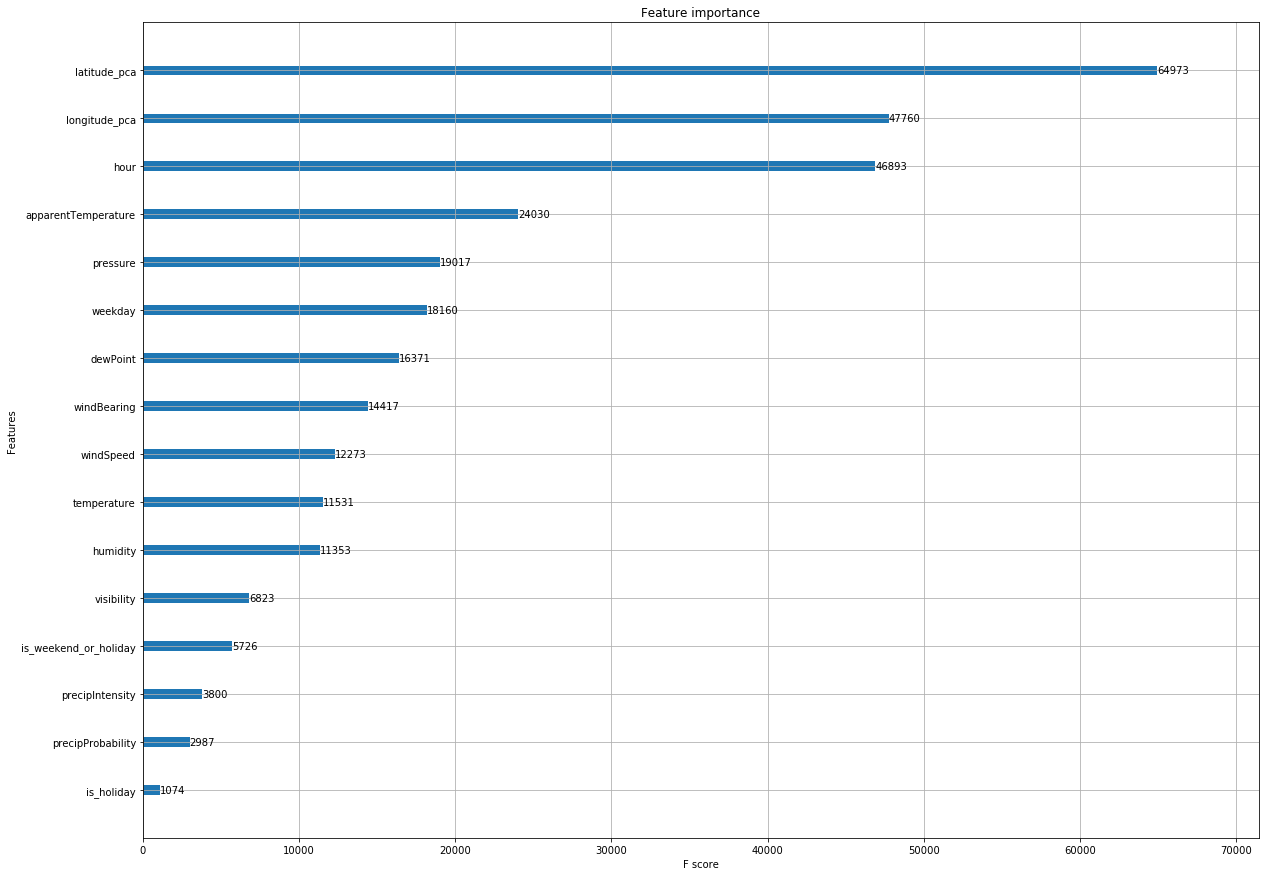

In [20]:
xgb.plot_importance(final_model)